In [1]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt



import statsmodels.api as sm
import statsmodels.tsa.api as smt

from timeit import default_timer as timer

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error




Anteriormente hemos realizado un analisis predictivo de partidos jugados y goles marcados por todos
los equipos en conjunto, ahora vamos a centrarnos en predecir los goles de 1 o 2 equipos unicamente

Nos enfocaremos en el Barcelona y en el Bayern

In [85]:


# Crear una lista para almacenar los datos de cada temporada
datos_temporadas = []

# Leer cada archivo CSV y agregar los datos en un DataFrame
carpeta = "CSVS"
archivos_csv = [archivo for archivo in os.listdir(carpeta) if archivo.endswith(".csv")]

for archivo in archivos_csv:
    # Extraer la fecha de la temporada del nombre del archivo
    fecha_temporada = archivo.split('.')[0]  # Suponiendo que la fecha está antes de la extensión .csv
    df_temporada = pd.read_csv(os.path.join(carpeta, archivo))
    # Agregar la columna de la temporada al DataFrame
    df_temporada['temporada'] = fecha_temporada
    datos_temporadas.append(df_temporada)

# Concatenar los DataFrames de todas las temporadas
datos_completos = pd.concat(datos_temporadas)

# Filtrar los partidos en los que el Barcelona es el equipo local o visitante
partidos_barcelona_local = datos_completos[datos_completos['equipo_local'] == 'Barcelona']
partidos_barcelona_visitante = datos_completos[datos_completos['equipo_visitante'] == 'Barcelona']

# Calcular la cantidad total de goles marcados por el Barcelona como local en cada temporada
goles_local_por_temporada = partidos_barcelona_local.groupby('temporada')['goles_equipo_local'].sum()

# Calcular la cantidad total de goles marcados por el Barcelona como visitante en cada temporada
goles_visitante_por_temporada = partidos_barcelona_visitante.groupby('temporada')['goles_equipo_visitante'].sum()

# Sumar los goles marcados por el Barcelona como local y visitante en cada temporada
goles_por_temporada = goles_local_por_temporada.add(goles_visitante_por_temporada, fill_value=0)

# Contar la cantidad de partidos jugados por el Barcelona en cada temporada
partidos_por_temporada = partidos_barcelona_local.groupby('temporada').size().add(partidos_barcelona_visitante.groupby('temporada').size(), fill_value=0)


# Crear un DataFrame con las estadísticas
estadisticas_barcelona = pd.DataFrame({
    'Temporada Barcelona': goles_por_temporada.index,
    'Goles Marcados Barcelona': goles_por_temporada.values,
    'Partidos Jugados Barcelona': partidos_por_temporada.values
})

# Mostrar el DataFrame
print(estadisticas_barcelona)

# Guardar el DataFrame en un archivo CSV
estadisticas_barcelona.to_csv('estadisticas_barcelona.csv', index=False)


  Temporada Barcelona  Goles Marcados Barcelona  Partidos Jugados Barcelona
0         temp2017_18                      16.0                          10
1         temp2019_20                      15.0                           9
2         temp2020_21                      18.0                           8
3         temp2021_22                       2.0                           6
4         temp2022_23                      12.0                           6
5         temp2023_24                      20.0                          10


Vamos a realizar ARIMA a estos datos para predecir los goles de la proxima temporada

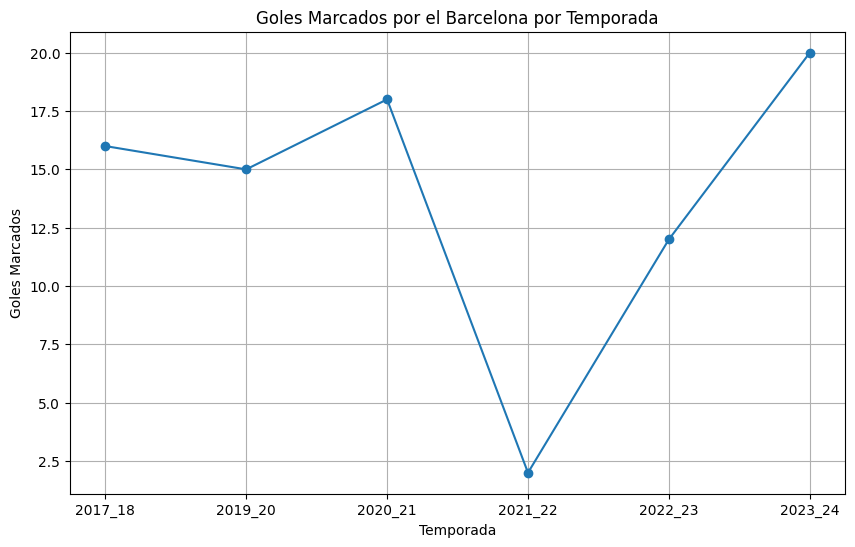

In [2]:
# Leer el DataFrame con las estadísticas del Barcelona
estadisticas_barcelona = pd.read_csv("estadisticas_barcelona.csv")

# Establecer la "Temporada Barcelona" como índice
estadisticas_barcelona.set_index('Temporada Barcelona', inplace=True)

# Visualizar los datos
plt.figure(figsize=(10, 6))
plt.plot(estadisticas_barcelona.index, estadisticas_barcelona['Goles Marcados Barcelona'], marker='o')
plt.title('Goles Marcados por el Barcelona por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Goles Marcados')
plt.grid(True)
plt.show()


Podemos observar los goles del Barcelona en cada temporada

c:\Users\usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observation

Error cuadrático medio: 61.462429749783695


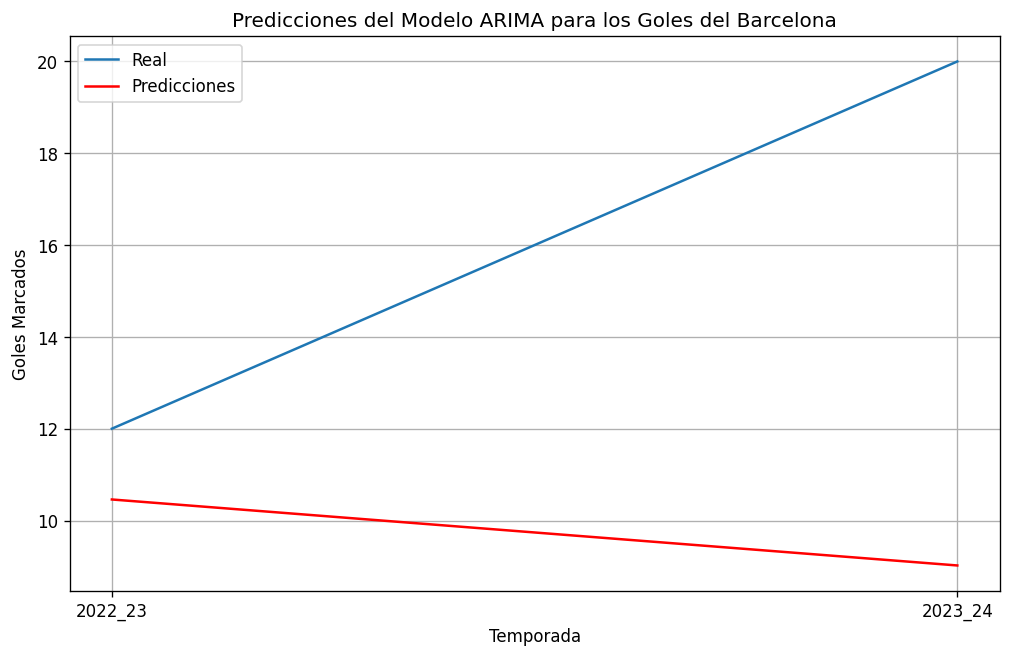

In [155]:

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(estadisticas_barcelona) * 0.7)

# Dividir los datos en entrenamiento y prueba
train = estadisticas_barcelona.iloc[:train_size]
test = estadisticas_barcelona.iloc[train_size:]

# Ajustar un modelo ARIMA
model = ARIMA(train['Goles Marcados Barcelona'], order=(5,1,1)) # ARIMA(p,d,q)
model_fit = model.fit()



# Hacer predicciones en el conjunto de prueba
predictions = model_fit.forecast(steps=len(test))

# Calcular el error cuadrático medio
mse = mean_squared_error(test['Goles Marcados Barcelona'], predictions)
print('Error cuadrático medio:', mse)

# Visualizar las predicciones
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Goles Marcados Barcelona'], label='Real')
plt.plot(test.index, predictions, color='red', label='Predicciones')
plt.title('Predicciones del Modelo ARIMA para los Goles del Barcelona')
plt.xlabel('Temporada')
plt.ylabel('Goles Marcados')
plt.legend()
plt.grid(True)
plt.show()

Como no tenemos muchos datos, el modelo Arima no se ajusta a la realidad en exceso.

Ahora vamos a ajustar el modelo y ver los resultados

c:\Users\usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observation

                                  SARIMAX Results                                   
Dep. Variable:     Goles Marcados Barcelona   No. Observations:                    6
Model:                       ARIMA(5, 1, 1)   Log Likelihood                 -12.607
Date:                      Fri, 03 May 2024   AIC                             39.214
Time:                              19:50:21   BIC                             36.480
Sample:                                   0   HQIC                            31.876
                                        - 6                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0562      0.007   -145.093      0.000      -1.071      -1.042
ar.L2         -0.0678      0.018     -3.712      0.000      -0.104      -0.032
ar.L

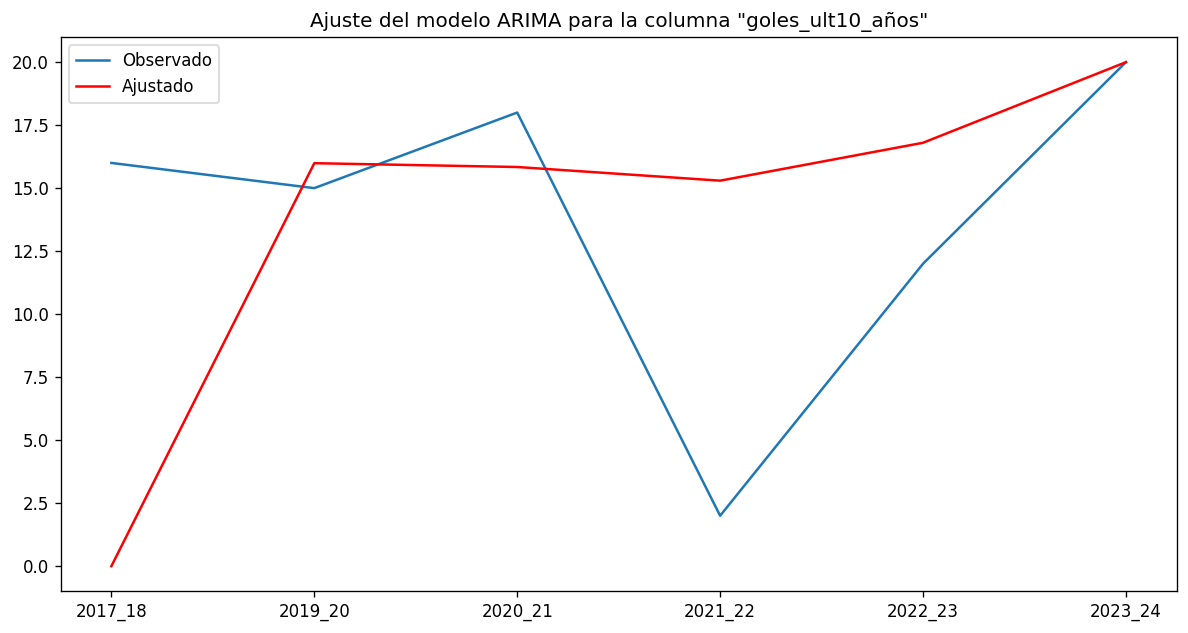

In [159]:
data = estadisticas_barcelona['Goles Marcados Barcelona']

# Definir el modelo ARIMA
order = (5, 1, 1)
model = ARIMA(data, order=order)


# Ajustar el modelo
fitted_model = model.fit()

# Obtener resumen del modelo
print(fitted_model.summary())

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(data, label='Observado')
plt.plot(fitted_model.fittedvalues, color='red', label='Ajustado')
plt.title('Ajuste del modelo ARIMA para la columna "Goles Marcados"')
plt.legend()
plt.show()

Podemos observar como se ajusta el modelo

Finalmente, vamos a predecir cuantos goles marcara el Barcelona en las proximas temporadas y utilizaremos la media de las ultimas
temporadas para ver cuantos partidos disputaran

In [161]:
# Hacer predicciones para la próxima temporada
next_season_prediction = model_fit.forecast(steps=2)
print('Predicción de goles para las próximas temporadas:', next_season_prediction.round())

# Calcular la cantidad de partidos para la próxima temporada (asumiendo un promedio histórico)
average_matches_per_season = estadisticas_barcelona['Partidos Jugados Barcelona'].mean()
next_season_matches = round(average_matches_per_season)
print('Número estimado de partidos para la próxima temporada:', next_season_matches)

Predicción de goles para las próximas temporadas: 4    10.0
5     9.0
Name: predicted_mean, dtype: float64
Número estimado de partidos para la próxima temporada: 8


c:\Users\usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Hemos predecido que en la proxima temporada marcara 10 goles en 8 partidos y en la siguiente 9

Hemos visto el modelos ARIMA del Barcelona, pero podemos profundizar un poco mas

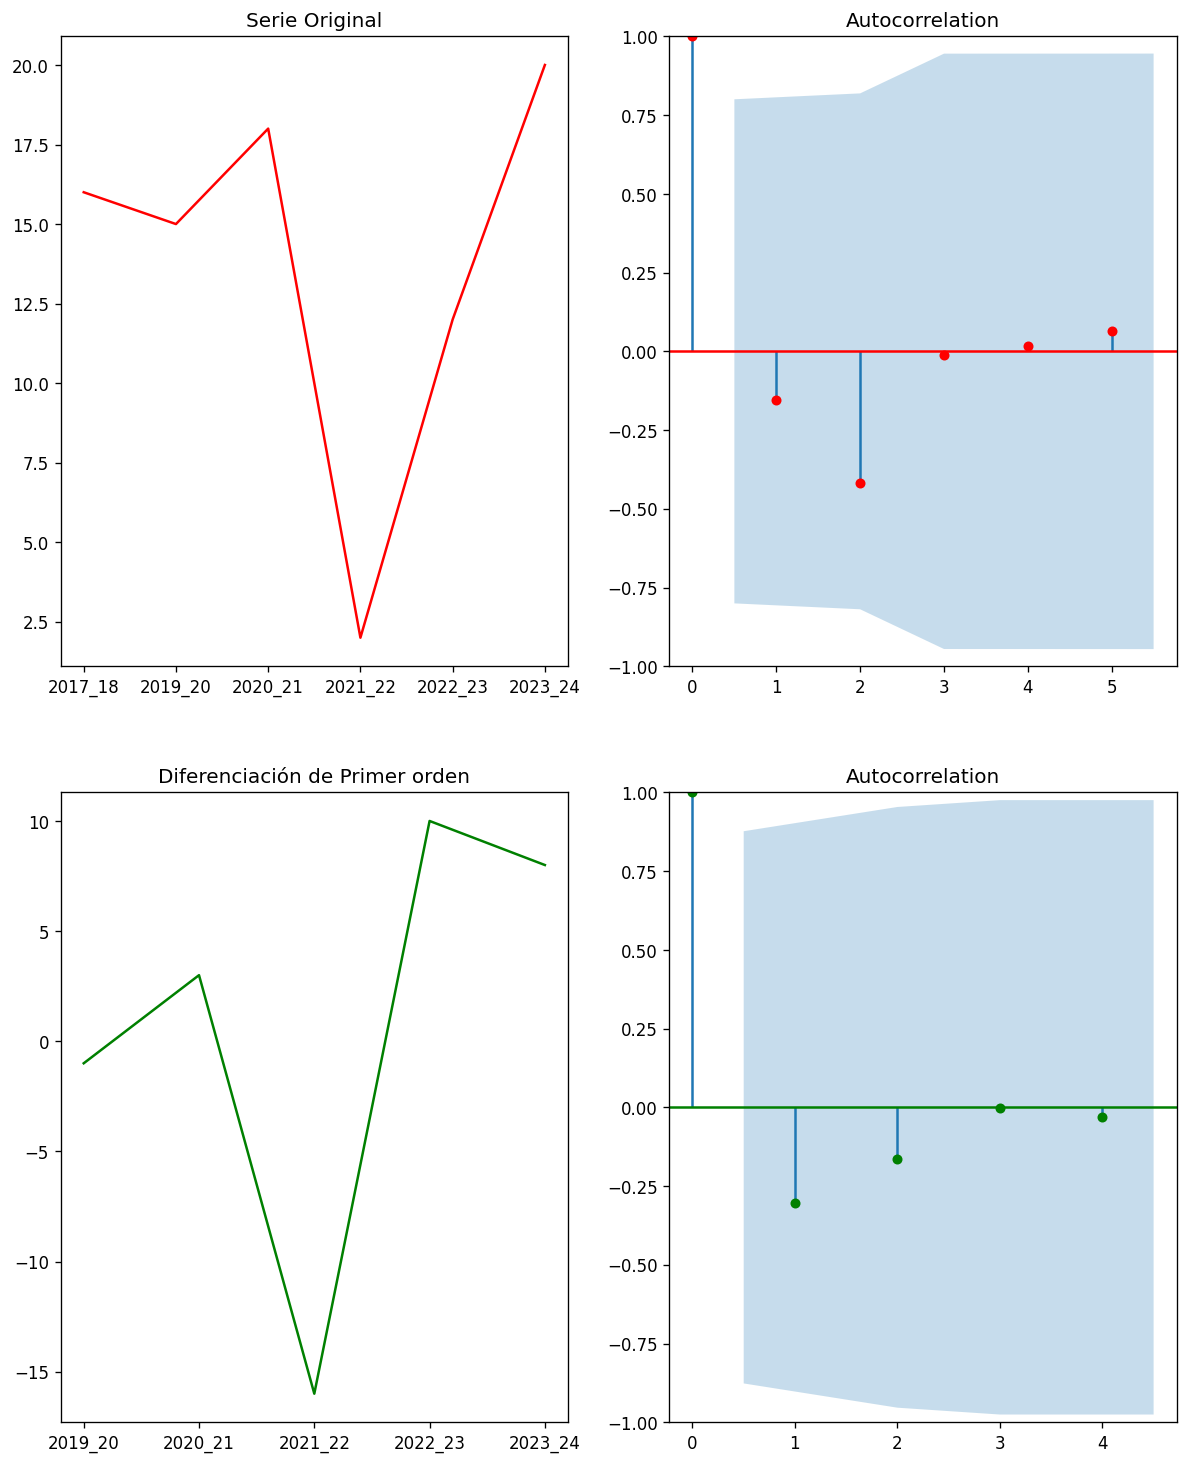

In [138]:
plt.rcParams.update({'figure.figsize':(12,15), 'figure.dpi':120})
# Serie Original
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(estadisticas_barcelona['Goles Marcados Barcelona'],color="r"); axes[0, 0].set_title('Serie Original')
plot_acf(estadisticas_barcelona['Goles Marcados Barcelona'], ax=axes[0, 1], color="r")

# Primera diferenciación 
axes[1, 0].plot(estadisticas_barcelona['Goles Marcados Barcelona'].diff(), color="g"); axes[1, 0].set_title("Diferenciación de Primer orden")
plot_acf(estadisticas_barcelona['Goles Marcados Barcelona'].diff().dropna(), ax=axes[1, 1],color="g")

plt.show();

Observamos que no son estacionarias

C:\Users\usuario\AppData\Local\Temp\ipykernel_15852\1414333121.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Goles Marcados Barcelona Forecast'] = goals_forecast


Error cuadrático medio: 24.458900000000003


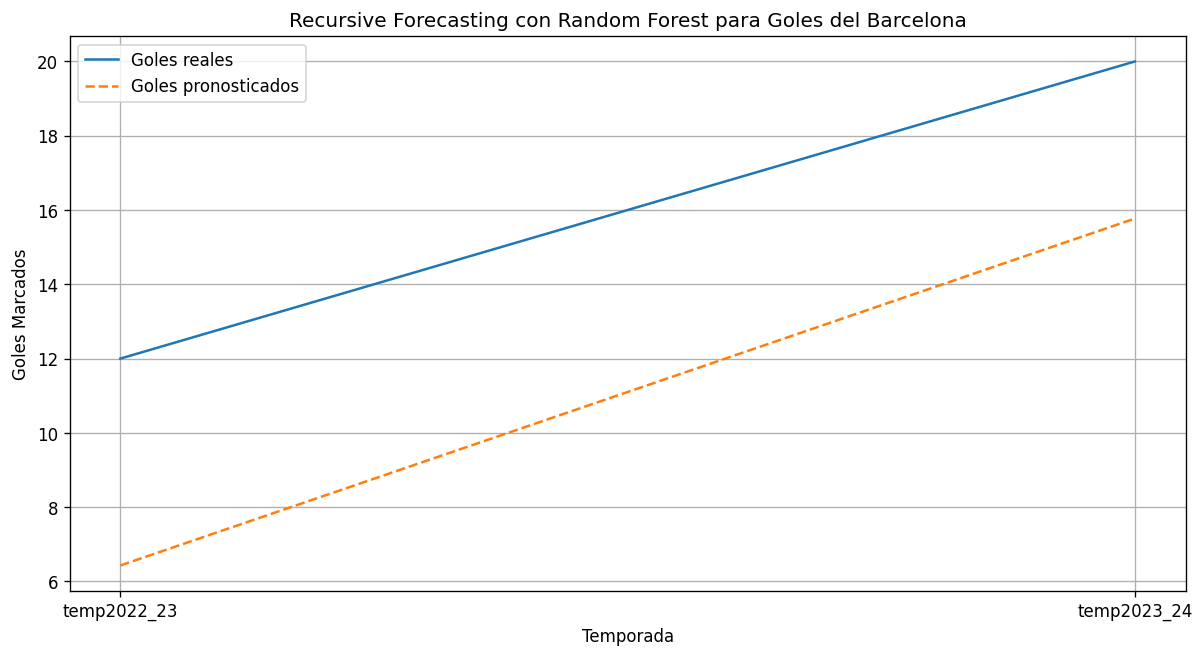

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Dividir el DataFrame en entrenamiento y prueba
train_size = int(len(estadisticas_barcelona) * 0.8)
train, test = estadisticas_barcelona.iloc[:train_size], estadisticas_barcelona.iloc[train_size:]

# Definir las características (X) y las etiquetas (y) para 'Goles Marcados Barcelona'
X_train, y_train = train.drop('Goles Marcados Barcelona', axis=1), train['Goles Marcados Barcelona']
X_test, y_test = test.drop('Goles Marcados Barcelona', axis=1), test['Goles Marcados Barcelona']

# Inicializar el modelo Random Forest para 'Goles Marcados Barcelona'
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Realizar Recursive Forecasting para 'Goles Marcados Barcelona'
goals_forecast = model.predict(X_test)
test['Goles Marcados Barcelona Forecast'] = goals_forecast

# Calcular el error cuadrático medio
mse = mean_squared_error(test['Goles Marcados Barcelona'], test['Goles Marcados Barcelona Forecast'])
print('Error cuadrático medio:', mse)

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Goles Marcados Barcelona'], label='Goles reales')
plt.plot(test.index, test['Goles Marcados Barcelona Forecast'], label='Goles pronosticados', linestyle='dashed')
plt.legend()
plt.title('Recursive Forecasting con Random Forest para Goles del Barcelona')
plt.xlabel('Temporada')
plt.ylabel('Goles Marcados')
plt.grid(True)
plt.show()


Disminuimos el error cuadratico usando RandomForestRegressor

Error cuadrático medio: 57.997489992296224


C:\Users\usuario\AppData\Local\Temp\ipykernel_20280\2013267593.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Goles Marcados Barcelona Forecast'] = goals_forecast


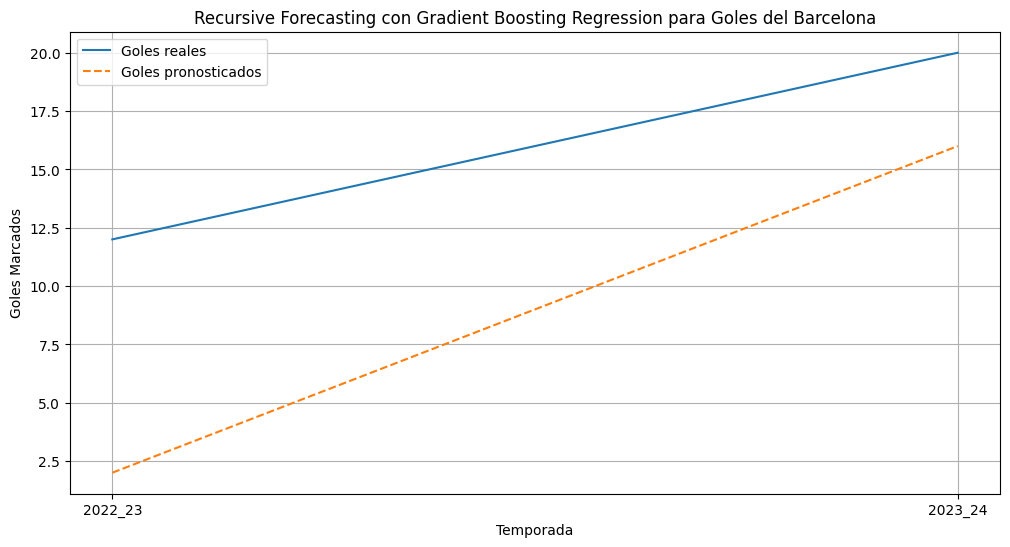

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Dividir el DataFrame en entrenamiento y prueba
train_size = int(len(estadisticas_barcelona) * 0.8)
train, test = estadisticas_barcelona.iloc[:train_size], estadisticas_barcelona.iloc[train_size:]

# Definir las características (X) y las etiquetas (y) para 'Goles Marcados Barcelona'
X_train, y_train = train.drop('Goles Marcados Barcelona', axis=1), train['Goles Marcados Barcelona']
X_test, y_test = test.drop('Goles Marcados Barcelona', axis=1), test['Goles Marcados Barcelona']

# Inicializar el modelo Gradient Boosting Regression para 'Goles Marcados Barcelona'
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Realizar Recursive Forecasting para 'Goles Marcados Barcelona'
goals_forecast = model.predict(X_test)
test['Goles Marcados Barcelona Forecast'] = goals_forecast

# Calcular el error cuadrático medio
mse = mean_squared_error(test['Goles Marcados Barcelona'], test['Goles Marcados Barcelona Forecast'])
print('Error cuadrático medio:', mse)

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Goles Marcados Barcelona'], label='Goles reales')
plt.plot(test.index, test['Goles Marcados Barcelona Forecast'], label='Goles pronosticados', linestyle='dashed')
plt.legend()
plt.title('Recursive Forecasting con Gradient Boosting Regression para Goles del Barcelona')
plt.xlabel('Temporada')
plt.ylabel('Goles Marcados')
plt.grid(True)
plt.show()


Con GradientBoostingRegressor  no conseguimos reducir el error

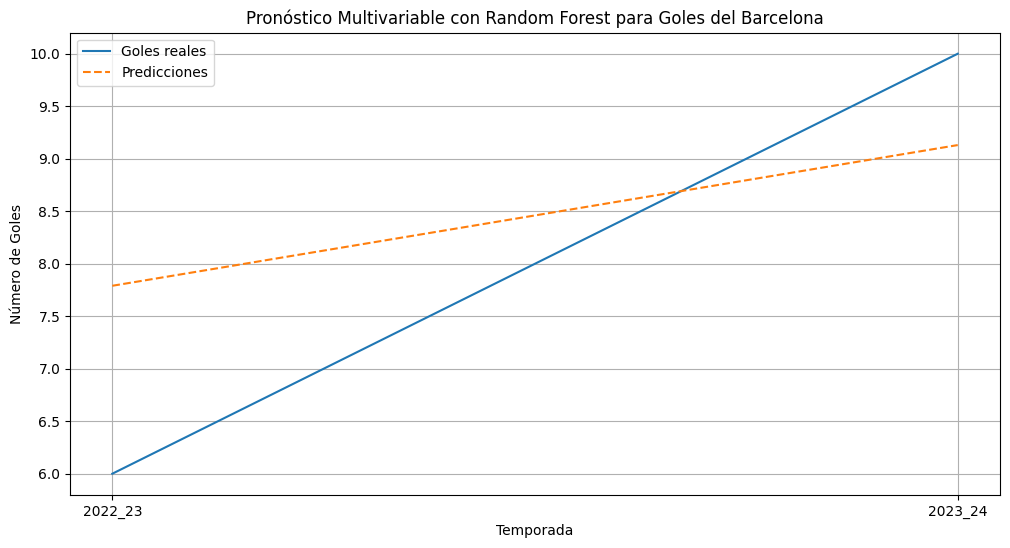

Error cuadrático medio: 1.9804999999999993


In [6]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Definir las características (X) y las etiquetas (y) para el modelo
features = ['Goles Marcados Barcelona', 'Partidos Jugados Barcelona']
X_train, y_train = train[features], train['Partidos Jugados Barcelona']
X_test, y_test = test[features], test['Partidos Jugados Barcelona']

# Inicializar el modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones para el conjunto de prueba
predictions = model.predict(X_test)

# Crear una copia de la sección de prueba antes de asignar las predicciones
test_copy = test.copy()

# Agregar las predicciones al DataFrame de prueba
test_copy['Predicciones'] = predictions

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(test_copy.index, test_copy['Partidos Jugados Barcelona'], label='Goles reales')
plt.plot(test_copy.index, test_copy['Predicciones'], label='Predicciones', linestyle='dashed')
plt.legend()
plt.xlabel('Temporada')
plt.ylabel('Número de Goles')
plt.title('Pronóstico Multivariable con Random Forest para Goles del Barcelona')
plt.grid(True)
plt.show()

from sklearn.metrics import mean_squared_error

# Calcular el error cuadrático medio
mse = mean_squared_error(test_copy['Partidos Jugados Barcelona'], predictions)
print('Error cuadrático medio:', mse)


Reducimos considerablemente el error, es un error que es valido para nuestros datos